### Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
### Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [4]:
def bias(y, z):
    return (y - z)

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
        else:
            target = gb_predict(X_train, trees, coefs, eta)
            tree.fit(X_train, bias(y_train, target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [6]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_mse = mean_squared_error(y_train, train_prediction)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_mse = mean_squared_error(y_test, test_prediction)
    
    return train_mse, test_mse

In [7]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [8]:
n_trees = 20
coefs = [1] * n_trees
eta = 0.1
tree_depths = np.arange(1, 25)
total_trees_counts = np.arange(1, 45, 3)
train_mse_list = []
test_mse_list = []

for max_depth in tree_depths:
    trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_mse, test_mse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

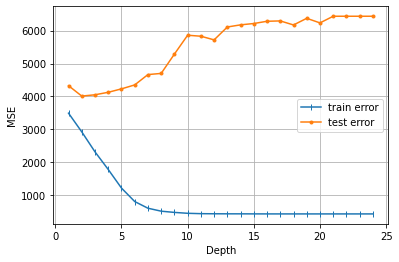

In [9]:
plt.plot(tree_depths, train_mse_list, marker='|', label='train error')
plt.plot(tree_depths, test_mse_list, marker='.', label='test error')
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

####  Большая глубина не приносит пользы, достаточно 3-4 уровней, потом модель переобучается.

In [10]:
eta = 0.1
max_depth = 3
total_trees_counts = np.arange(1, 45, 3)
train_mse_list = []
test_mse_list = []

for n_trees in total_trees_counts:
    trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_mse, test_mse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

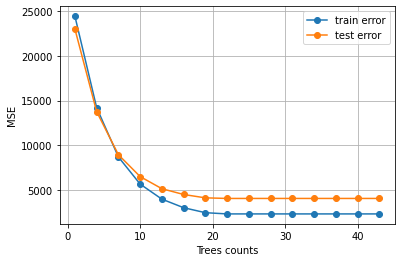

In [11]:
plt.plot(total_trees_counts, train_mse_list, marker='o', label='train error')
plt.plot(total_trees_counts, test_mse_list, marker='o', label='test error')
plt.xlabel('Trees counts')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Большое количество деревьев не приносит пользы, достаточно 8-10 штук.

### Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
### Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [12]:
def gb_s_fit(n_trees, max_depth, X_train_all, X_test, y_train_all, y_test, coefs, eta, sample_coef):

    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        s = int(X_train_all.shape[0] * sample_coef)
        con_xy = np.c_[X_train_all, y_train_all]
        data = np.random.permutation(con_xy)[:s]
        X_train = data[:, :-1]
        y_train = data[:, -1]


        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            target = gb_predict(X_train, trees, coefs, eta)
            
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [13]:
n_trees = 10
coefs = [1] * n_trees
max_depth = 5
eta = 1

trees_1, train_errors_1, test_errors_1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_2, train_errors_2, test_errors_2 = gb_s_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sample_coef=0.5)

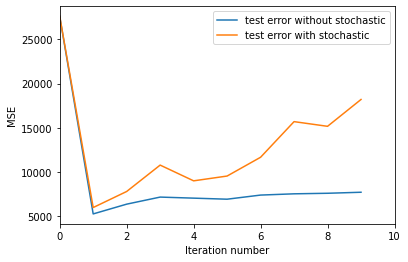

In [14]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors_1, label='test error without stochastic')
plt.plot(list(range(n_trees)), test_errors_2, label='test error with stochastic')
plt.legend(loc='upper right')
plt.show()

#### Модель стохастического градиентного бустинга показывает несколько худшее качество.